# Synopsis

![OpenBabel](http://openbabel.org/babel130.png)

In this kernel I will explore an alternative way of calculating local `mulliken charges`. 
You may be interrested only if you wish to incorportate these features in your model.  
=> The charges calculated with Open Babel are available as an autonomous dataset in [Open Babel Atom Charges](https://www.kaggle.com/asauve/open-babel-atom-charges)

The [Open Babel](http://openbabel.org/wiki/Main_Page) Package allow to
* Read .xyz files (the ones provided in the structures directory)
* Build bonding scheme (groovy baby!)
* Compute partial charges, with several builtin methods

Humm this last one is really interresting as it provides a quick way of computing atoms local charge with a method based on linear algebra. Hence it is fast and in the range of the allowed options for the competition.

The most promising method is Electronegativity Equalization Method  (EEM) which is describeed in this paper:  
[High-quality and universal empirical atomic charges for chemoinformatics applications](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4667495/)




# Changelog

* v7 : Include test molecules in a separate dataframe and updated the external dataset accordingly
* v5 : building of output dataset `ob_charges` with train molecules
* v4 : first public version


# Definition of partial charge

There is no such thing as a space localized electron, they are rather something like a wave all around atomic nuclei. But there are some models for getting an approximation of the average charge at the location of atoms. This is this what is computed in this kernel under the name partial charge. 

Open babel offers several methods to compute these values (you have to dig into the code to get them) which are all provided under the column with the matching name.

# Load Data

In [1]:
import numpy as np # linear algebra
from scipy.stats.stats import pearsonr
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm_notebook as tqdm
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set()
import os

Load CSV data

In [2]:
def load_dir_csv(directory, csv_files=None):
    if csv_files is None:
        csv_files = sorted( [ f for f in os.listdir(directory) if f.endswith(".csv") ])    
    csv_vars  = [ filename[:-4] for filename in csv_files ]
    gdict = globals()
    for filename, var in zip( csv_files, csv_vars ):
        print(f"{var:32s} = pd.read_csv({directory}/{filename})")
        gdict[var] = pd.read_csv( f"{directory}/{filename}" )
        print(f"{'nb of cols ':32s} = " + str(len(gdict[var])))
        display(gdict[var].head())

load_dir_csv("../input/", 
             ["train.csv", "test.csv", "structures.csv", "mulliken_charges.csv"])


train                            = pd.read_csv(../input//train.csv)
nb of cols                       = 4658147


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


test                             = pd.read_csv(../input//test.csv)
nb of cols                       = 2505542


,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


structures                       = pd.read_csv(../input//structures.csv)
nb of cols                       = 2358657


,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


mulliken_charges                 = pd.read_csv(../input//mulliken_charges.csv)
nb of cols                       = 1533537


,molecule_name,atom_index,mulliken_charge
0,dsgdb9nsd_000001,0,-0.535689
1,dsgdb9nsd_000001,1,0.133921
2,dsgdb9nsd_000001,2,0.133922
3,dsgdb9nsd_000001,3,0.133923
4,dsgdb9nsd_000001,4,0.133923


# Install OpenBabel

The installation method was  demonstrated in: [Molecule with OpenBabel](https://www.kaggle.com/jmtest/molecule-with-openbabel)

In [3]:
!conda install -y -c openbabel openbabel 
import openbabel as ob

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openbabel


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.5.15  |                0         133 KB
    libgcc-7.2.0               |       h69d50b8_2         304 KB
    openbabel-2.4.1            |           py36_5         5.1 MB  openbabel
    openssl-1.0.2s             |       h7b6447c_0         3.1 MB
    ------------------------------------------------------------
                                           Total:         8.7 MB

The following NEW packages will be INSTALLED:

  libgcc             pkgs/main/linux-64::libgcc-7.2.0-h69d50b8_2
  openbabel          openbabel/linux-64::openbabel-2.4.1-py36_5

The following packages will be UPDATED:

  ca-certificates                               2019.1.23-0 --> 2019.5.15-0
  openssl                         

# Load Mulliken Charges from train set

In [4]:
# differentiate train and test set
train_molecules = train.molecule_name.unique()
test_molecules  = test.molecule_name.unique()


mulliken   = []
mulliken_charges_idx = mulliken_charges.set_index(['molecule_name'])
# ensure mulliken charges are in same order as for partial charges
for molecule_name in train_molecules:
    mc  = mulliken_charges_idx.loc[molecule_name].sort_index()
    mulliken.extend(mc.mulliken_charge.values)

# Compute atom partial charges with Open Babel 

In [5]:
##
## Build molecules from files.xyz
##

obConversion = ob.OBConversion()
#def read_ob_molecule(molecule_name, datadir="../input/champs-scalar-coupling/structures"):
def read_ob_molecule(molecule_name, datadir="../input/structures"):
    mol = ob.OBMol()
    path = f"{datadir}/{molecule_name}.xyz"
    if not obConversion.ReadFile(mol, path):
        raise FileNotFoundError(f"Could not read molecule {path}")
    return mol
    

ob_methods = [ "eem", "mmff94", "gasteiger", "qeq", "qtpie", 
               "eem2015ha", "eem2015hm", "eem2015hn", "eem2015ba", "eem2015bm", "eem2015bn" ]

structures_idx = structures.set_index( ["molecule_name"] )
def get_charges_df(molecule_names):
    ob_methods_charges = [ [] for _ in ob_methods]
    ob_molecule_name = []  # container for output  DF
    ob_atom_index    = []  # container for output  DF
    ob_error         = []
    for molecule_name in molecule_names:
        # fill data for output DF
        ms = structures_idx.loc[molecule_name].sort_index()
        natoms = len(ms)
        ob_molecule_name.extend( [molecule_name] * natoms )
        ob_atom_index.extend(    ms.atom_index.values )

        # calculate open babel charge for each method
        mol = read_ob_molecule(molecule_name)
        assert( mol.NumAtoms() == natoms ) # consistency
        error = 0
        for method, charges in zip(ob_methods, ob_methods_charges):
            ob_charge_model = ob.OBChargeModel.FindType(method)
            if not ob_charge_model.ComputeCharges(mol):
                error = 1
            charges.extend( ob_charge_model.GetPartialCharges() )
        ob_error.extend([error] * natoms)
            
    ob_charges = pd.DataFrame({
        'molecule_name' : ob_molecule_name,
        'atom_index'    : ob_atom_index}
    )
    for method, charges in zip(ob_methods, ob_methods_charges):
        ob_charges[method] = charges
    ob_charges["error"] = ob_error
    display(ob_charges.head())
    return ob_charges

In [6]:
%time train_ob_charges = get_charges_df(train_molecules)

,molecule_name,atom_index,eem,mmff94,gasteiger,qeq,qtpie,eem2015ha,eem2015hm,eem2015hn,eem2015ba,eem2015bm,eem2015bn,error
0,dsgdb9nsd_000001,0,-0.644531,0.0,-0.077596,3.251140,-3.093807,0.014606,-0.813021,-0.784944,-0.067349,-0.806339,-0.851258,0
1,dsgdb9nsd_000001,1,0.161131,0.0,0.019399,-0.812772,0.773439,-0.003651,0.203254,0.196234,0.016837,0.201583,0.212813,0
2,dsgdb9nsd_000001,2,0.161132,0.0,0.019399,-0.812776,0.773442,-0.003651,0.203254,0.196235,0.016837,0.201584,0.212813,0
3,dsgdb9nsd_000001,3,0.161134,0.0,0.019399,-0.812797,0.773463,-0.003651,0.203256,0.196237,0.016837,0.201586,0.212816,0
4,dsgdb9nsd_000001,4,0.161134,0.0,0.019399,-0.812795,0.773462,-0.003651,0.203256,0.196237,0.016837,0.201586,0.212816,0


CPU times: user 6min 7s, sys: 14.7 s, total: 6min 22s
Wall time: 8min 13s


In [7]:
%time test_ob_charges = get_charges_df(test_molecules)

,molecule_name,atom_index,eem,mmff94,gasteiger,qeq,qtpie,eem2015ha,eem2015hm,eem2015hn,eem2015ba,eem2015bm,eem2015bn,error
0,dsgdb9nsd_000004,0,-0.140218,-0.177,-0.195499,0.162134,-0.104823,0.186739,-0.244665,-0.126079,0.188397,-0.232962,-0.126054,0
1,dsgdb9nsd_000004,1,-0.140218,-0.177,-0.195499,0.162134,-0.104823,0.186739,-0.244665,-0.126079,0.188397,-0.232962,-0.126054,0
2,dsgdb9nsd_000004,2,0.140218,0.177,0.195499,-0.162134,0.104823,-0.186739,0.244665,0.126079,-0.188397,0.232962,0.126054,0
3,dsgdb9nsd_000004,3,0.140218,0.177,0.195499,-0.162134,0.104823,-0.186739,0.244665,0.126079,-0.188397,0.232962,0.126054,0
4,dsgdb9nsd_000015,0,-0.200372,0.280,-0.018924,-0.438607,0.348798,0.462935,-0.319256,-0.257585,0.347919,-0.405719,-0.346147,0


CPU times: user 3min 19s, sys: 8.03 s, total: 3min 28s
Wall time: 4min 26s


# Compare Mulliken charges to Open Babel EEM

method = eem         corr =  0.9320
method = mmff94      corr =  0.5796
method = gasteiger   corr =  0.6899
method = qeq         corr = -0.7894
method = qtpie       corr =  0.7563
method = eem2015ha   corr =  0.5998
method = eem2015hm   corr =  0.9078
method = eem2015hn   corr =  0.9266
method = eem2015ba   corr =  0.6473
method = eem2015bm   corr =  0.8564
method = eem2015bn   corr =  0.9378


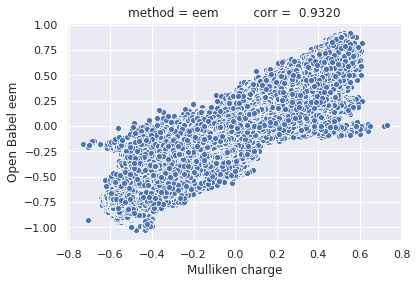

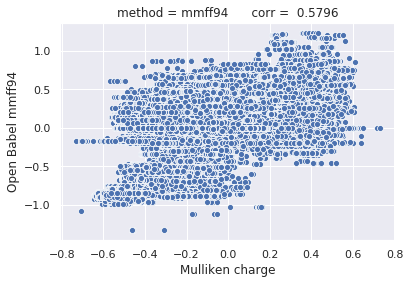

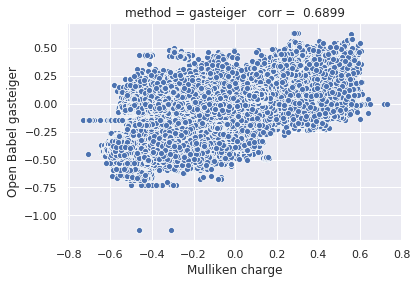

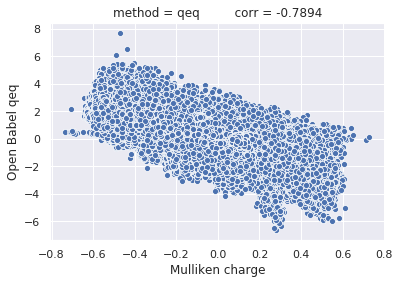

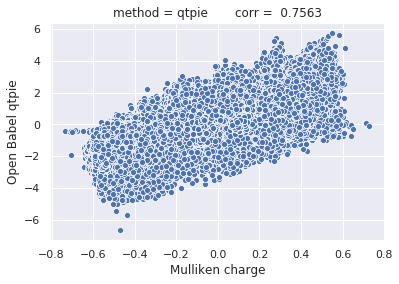

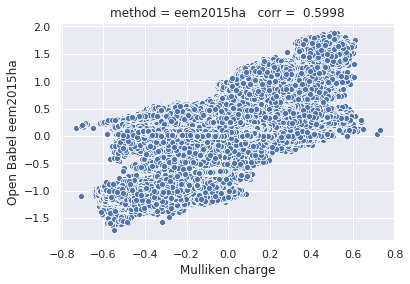

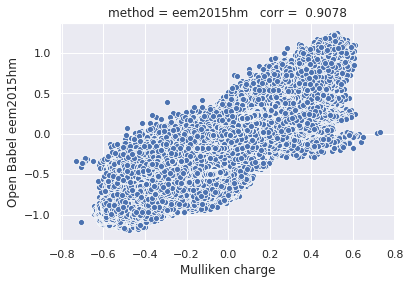

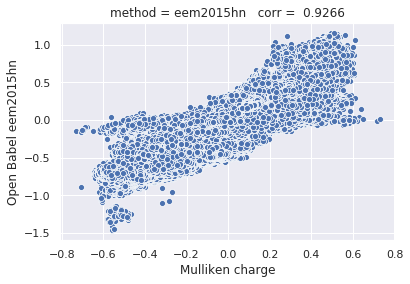

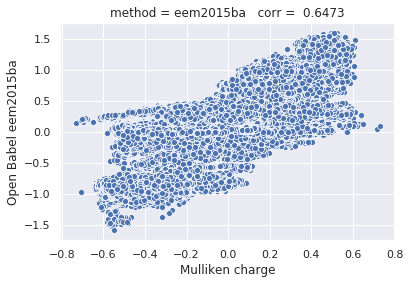

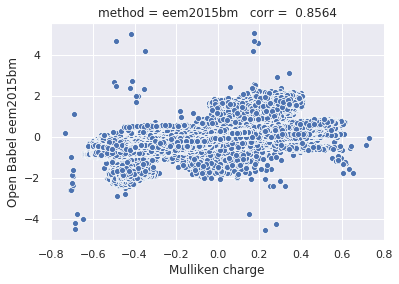

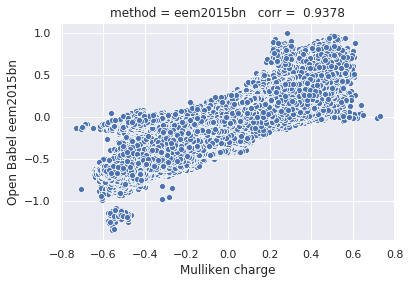

In [8]:
# correlation plots
corrs = []
for method in ob_methods:
    charges = train_ob_charges[method].values
    fig = plt.figure()
    ax = sns.scatterplot(mulliken, charges)
    corr, pval = pearsonr(mulliken, charges)
    corrs.append(corr)
    title = f"method = {method:10s}  corr = {corr:7.4f}"
    print(title)
    plt.title(title)
    plt.xlabel("Mulliken charge")
    plt.ylabel(f"Open Babel {method}")


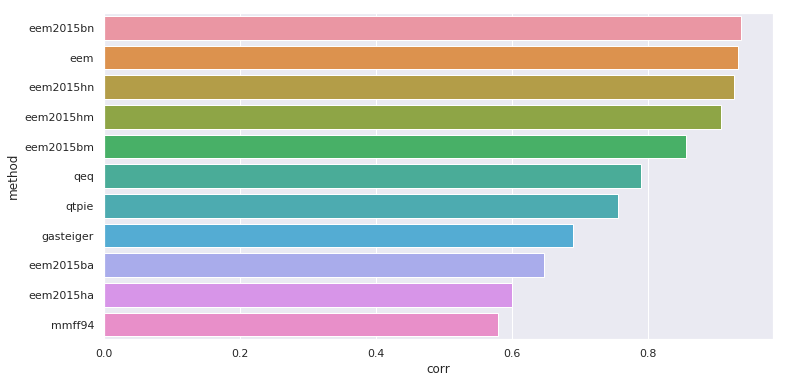

In [9]:
fig = plt.figure(figsize=(12,6))
data = pd.DataFrame( {'method':ob_methods, 'corr':[abs(c) for c in corrs]}).sort_values('corr', ascending=False)
ax = sns.barplot(data=data, x='corr', y='method', orient="h", dodge=False)

# Write Output dataframes

In [10]:
train_ob_charges.to_csv("train_ob_charges.csv")
test_ob_charges.to_csv("test_ob_charges.csv")

# Conclusion

Open Babel local charge estimation is worth a try in our models!

Best match is method **"eem"** and some of its variants!

Note that some outliers in the scatter plots come from different convention for how ionization charge is located inside the molecule. For example COO- can have -1 charge set on one O, or let it be shared by both oxygens. Hence the fact that some models differ from the data in the table `mulliken_charges` does not mean that it is systematically worse for the end purpose to predict coupling.
